In [1]:
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as stl
stl.use("ggplot")
import seaborn as sns
import os
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [3]:
data_folder = '../input/fire-dataset/fire_dataset'

train_data_folder = '../input/fire-dataset/fire_dataset/fire_images'
test_date_folder  = '../input/fire-dataset/fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []

    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}/{}'.format(data_folder,category,path), i, category])

2it [00:00, 17.39it/s]


In [4]:
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [5]:
data = pd.DataFrame(train_data, columns=['path', 'id', 'label'])
data.shape
data.head()

,path,id,label
0,../input/fire-dataset/fire_dataset/fire_images...,0,fire_images
1,../input/fire-dataset/fire_dataset/fire_images...,0,fire_images
2,../input/fire-dataset/fire_dataset/fire_images...,0,fire_images
3,../input/fire-dataset/fire_dataset/fire_images...,0,fire_images
4,../input/fire-dataset/fire_dataset/fire_images...,0,fire_images


In [6]:
data["path"]

0      ../input/fire-dataset/fire_dataset/fire_images...
1      ../input/fire-dataset/fire_dataset/fire_images...
2      ../input/fire-dataset/fire_dataset/fire_images...
3      ../input/fire-dataset/fire_dataset/fire_images...
4      ../input/fire-dataset/fire_dataset/fire_images...
                             ...                        
994    ../input/fire-dataset/fire_dataset/non_fire_im...
995    ../input/fire-dataset/fire_dataset/non_fire_im...
996    ../input/fire-dataset/fire_dataset/non_fire_im...
997    ../input/fire-dataset/fire_dataset/non_fire_im...
998    ../input/fire-dataset/fire_dataset/non_fire_im...
Name: path, Length: 999, dtype: object

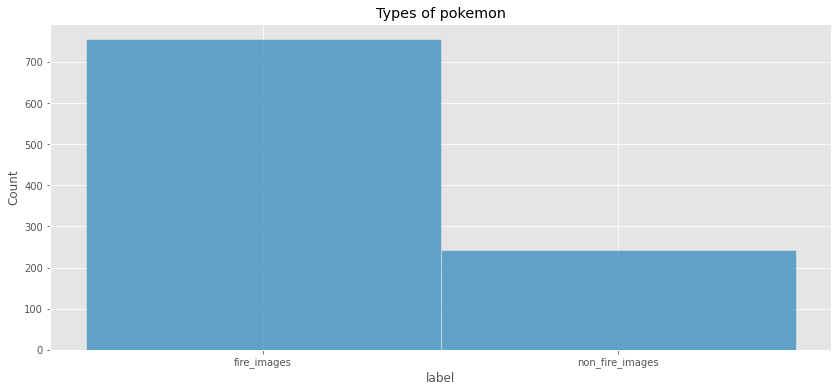

In [7]:
plt.figure(figsize=(14, 6))
sns.histplot(x=data["label"])
plt.title('Types of pokemon')
plt.show()

In [8]:
from keras.preprocessing import image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

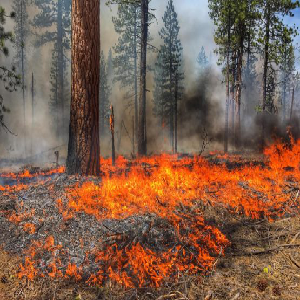

In [9]:
from tensorflow.keras.preprocessing.image import load_img
path0='../input/fire-dataset/fire_dataset/fire_images/fire.140.png'
load_img(path0,target_size=(300,300))

In [10]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

In [11]:
y=data["id"]

In [12]:
train_x, train_val, y_train, y_val = train_test_split(data["label"], y, test_size=0.2, random_state=101)

In [13]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


In [14]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.1)

In [15]:
train_generator = train_datagenerator.flow_from_dataframe(
    data, 
    x_col='path', 
    y_col='label',
    target_size=(120, 120), 
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    subset='training')
validation_generator = train_datagenerator.flow_from_dataframe(
    data , 
    x_col='path', 
    y_col='label',
    target_size=(120, 120),
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=4, 
    shuffle=True,
    seed=1, 
    subset='validation'
)

Found 900 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.


In [16]:
model = ks.models.Sequential()

model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))


model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))


model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))


model.add(ks.layers.Flatten())

model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

2022-05-01 15:09:46.583057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 15:09:46.694635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 15:09:46.695417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 15:09:46.696573: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120, 120, 4)       20        
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 64)      2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0

In [18]:
model.layers

In [19]:
history = model.fit_generator(
    train_generator, 
    epochs=5,
    validation_data=validation_generator)

2022-05-01 15:09:50.009007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-05-01 15:09:53.597851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


29/29 [==============================] - 46s 1s/step - loss: 0.5521 - acc: 0.7478 - val_loss: 0.3671 - val_acc: 0.6566
Epoch 2/5
29/29 [==============================] - 31s 1s/step - loss: 0.2840 - acc: 0.8744 - val_loss: 0.0872 - val_acc: 0.9596
Epoch 3/5
29/29 [==============================] - 33s 1s/step - loss: 0.4098 - acc: 0.8867 - val_loss: 0.2483 - val_acc: 0.8384
Epoch 4/5
29/29 [==============================] - 32s 1s/step - loss: 0.2827 - acc: 0.8933 - val_loss: 0.0848 - val_acc: 0.9495
Epoch 5/5
29/29 [==============================] - 33s 1s/step - loss: 0.2149 - acc: 0.9122 - val_loss: 0.1985 - val_acc: 0.8788


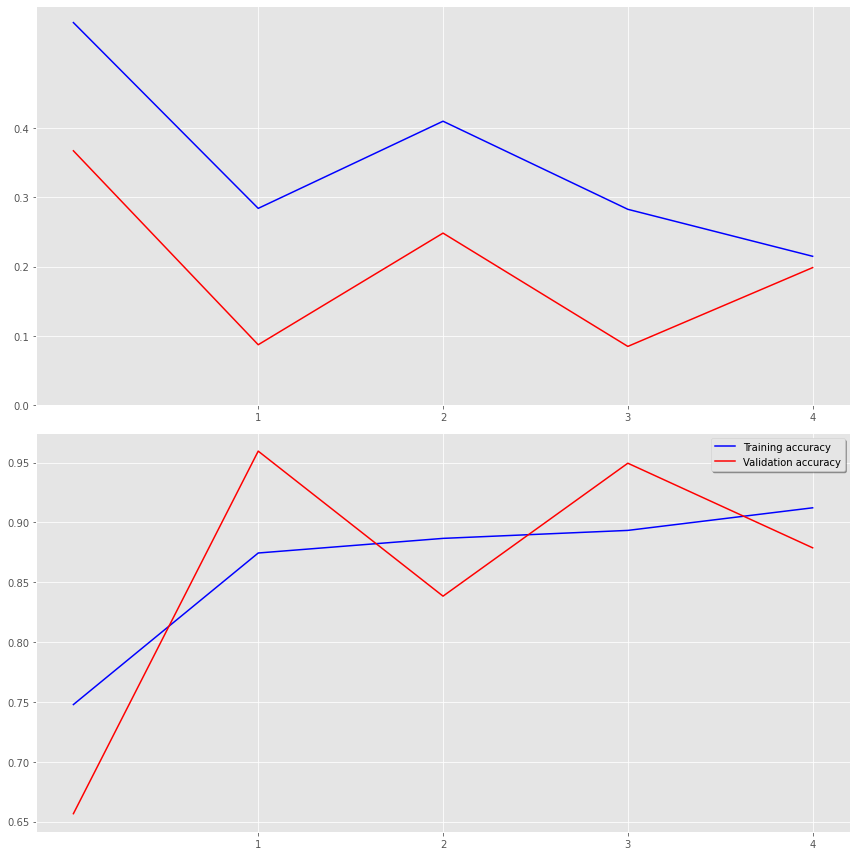

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 5, 1))
ax1.set_yticks(np.arange(0, 0.5, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 5, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()